In [58]:
# Core libraries
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh



In [59]:
# ===========================
# Load and preprocess dataset
# ===========================

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/Shared drives/GNN/RestingStateDataforAlex_3Networks.xlsx'
df = pd.read_excel(file_path)


print(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        SID  ABS_Attention_LDLPFC-Attention_RDLPFC  \
0    epp270                               0.588318   
1    epp271                               0.681967   
2    epp278                               0.357294   
3    epp309                               0.648362   
4    epp314                               0.041228   
..      ...                                    ...   
210  epc260                               0.486754   
211  epc261                               0.462012   
212  epc262                               0.174866   
213  epc263                               0.755232   
214  epc265                               0.176893   

     ABS_Attention_LDLPFC-Attention_LIPL  ABS_Attention_RDLPFC-Attention_LIPL  \
0                               0.173388                             0.072191   
1                               0.933840                    

In [ ]:
#creating graphs


# Drop SID column and get all edge columns
edge_columns = df.columns.drop('SID')

# Extract all unique node names (stripped of 'ABS_' if present)
nodes_set = set()
for col in edge_columns:
    raw_node1, raw_node2 = col.split('-')
    node1 = raw_node1.replace('ABS_', '')
    node2 = raw_node2.replace('ABS_', '')
    nodes_set.add(node1)
    nodes_set.add(node2)

# Sort nodes for consistent ordering
nodes = sorted(list(nodes_set))
n_nodes = len(nodes)

# Map node name to index
node_to_idx = {node: i for i, node in enumerate(nodes)}

# Separate edges into ABS and non-ABS edges
abs_edge_cols = []
rel_edge_cols = []
abs_edge_to_idx = []
rel_edge_to_idx = []

for col in edge_columns:
    raw_node1, raw_node2 = col.split('-')
    node1 = raw_node1.replace('ABS_', '')
    node2 = raw_node2.replace('ABS_', '')
    idx1, idx2 = node_to_idx[node1], node_to_idx[node2]

    if 'ABS_' in col:
        abs_edge_cols.append(col)
        abs_edge_to_idx.append((idx1, idx2))
    else:
        rel_edge_cols.append(col)
        rel_edge_to_idx.append((idx1, idx2))

# Build adjacency matrices for each row
abs_adj_matrices = []
rel_adj_matrices = []

for _, row in df.iterrows():
    # Create zero matrices for ABS and relative graphs
    abs_adj = np.zeros((n_nodes, n_nodes))
    rel_adj = np.zeros((n_nodes, n_nodes))

    # Fill ABS adjacency matrix
    for col_idx, (i1, i2) in enumerate(abs_edge_to_idx):
        val = row[abs_edge_cols[col_idx]]
        abs_adj[i1, i2] = val
        abs_adj[i2, i1] = val  # symmetric

    # Fill relative adjacency matrix
    for col_idx, (i1, i2) in enumerate(rel_edge_to_idx):
        val = row[rel_edge_cols[col_idx]]
        rel_adj[i1, i2] = val
        rel_adj[i2, i1] = val  # symmetric

    abs_adj_matrices.append(abs_adj)
    rel_adj_matrices.append(rel_adj)


In [ ]:
#making a dictionary of sid to absolute graph and relative graph

graphs_by_sid = {}

for sid, abs_mat, rel_mat in zip(df['SID'], abs_adj_matrices, rel_adj_matrices):
    graphs_by_sid[sid] = {
        'abs': abs_mat,
        'rel': rel_mat
    }

print(graphs_by_sid['epp348']['rel'])  # Relative graph
print(graphs_by_sid['epp348']['rel'].shape)

[[ 0.          0.6443512   0.60952988  0.48149378  0.21855582  0.02744795
   0.19705619 -0.14626492 -0.20716272 -0.01932991 -0.15652164 -0.28049982
  -0.17138803 -0.17873779 -0.05382542]
 [ 0.6443512   0.          0.53500292  0.64447851  0.71385829  0.0261051
   0.44132225 -0.55944315 -0.61724242 -0.10934934 -0.25394405 -0.15493399
  -0.18232735 -0.12858349 -0.11987415]
 [ 0.60952988  0.53500292  0.          0.50661799  0.37571928  0.42134627
   0.04587733 -0.12207047 -0.50220895 -0.05944264  0.08870163  0.1442684
  -0.41469532  0.02158323 -0.22569421]
 [ 0.48149378  0.64447851  0.50661799  0.          1.09910671  0.18484547
   0.21678365 -0.36616225 -0.53407179 -0.16535064 -0.03218564  0.05986651
  -0.11841703 -0.09234453 -0.26826495]
 [ 0.21855582  0.71385829  0.37571928  1.09910671  0.          0.10228209
   0.24679883 -0.45983477 -0.57815033 -0.17797306  0.07242114  0.08410655
  -0.13201032 -0.1261167  -0.20566083]
 [ 0.02744795  0.0261051   0.42134627  0.18484547  0.10228209  0.
 

In [ ]:
#threshholding the connectivity graph

def threshold_graph(A, keep_fraction=0.4):
    triu_indices = np.triu_indices_from(A, k=1)                     #get upper triangle indices above the diagonal
    edge_values = A[triu_indices]                                   #get all edge values of upper triangle values
    threshold = np.percentile(edge_values, 100*(1-keep_fraction))   #60% weakest means keep top 40%
    mask = A >= threshold
    A_thresh = A * mask
    A_thresh = np.maximum(A_thresh, A_thresh.T)                     #ensure symmetry
    return A_thresh

#print(graphs_by_sid['epp348']['abs'])

for sid, graphs in graphs_by_sid.items():
    graphs_by_sid[sid]['abs'] = threshold_graph(graphs['abs'], keep_fraction=0.3)
    graphs_by_sid[sid]['rel'] = threshold_graph(graphs['rel'], keep_fraction=0.3)

#print(graphs_by_sid['epp348']['abs'])




NameError: name 'graphs_by_sid' is not defined

In [ ]:
#adding to dictionary demographic data and labels.


demo_cols = ['Age', 'handedness', 'sex', 'PrimaryEthnicity', 'PrimaryRace','Education','Parental Education']
outcome = ['Imp20PercentBPRS']
df_labels = pd.read_excel(file_path, sheet_name='outcomeanddemographics', skiprows=1)

print(df_labels.head())
print(df_labels.columns.tolist())

demo_dict = df_labels.set_index('SID')[demo_cols].to_dict(orient='index')

graphs_by_sid = {}

for sid, abs_mat, rel_mat in zip(df['SID'], abs_adj_matrices, rel_adj_matrices):
    demos = demo_dict.get(sid, None)
    graphs_by_sid[sid] = {
        'abs': abs_mat,
        'rel': rel_mat,
        'demo': demos,
        'outcome': df_labels.loc[df_labels['SID'] == sid, outcome].values[0][0] if sid in df_labels['SID'].values else None
    }

#print(graphs_by_sid['epp270'])  # Relative graph

graphs_by_sid = {
    sid: graph
    for sid, graph in graphs_by_sid.items()
    if graph.get('outcome') is not None
}

print(len(graphs_by_sid))
print(graphs_by_sid['epp270']['abs'])
print(graphs_by_sid['epp270'])

outcome_count = sum(1 for graph in graphs_by_sid.values() if graph.get('outcome') == 1)
outcome_count_zero = sum(1 for graph in graphs_by_sid.values() if graph.get('outcome') == 0)
print(f"Number of instances with outcome == 1: {outcome_count}")
print(f"Number of instances with outcome == 0: {outcome_count_zero}")


#Number of instances with outcome == 1: 29
#Number of instances with outcome == 0: 27

      SID  Imp20PercentBPRS  Age  handedness  sex  PrimaryEthnicity  \
0  epp270                 1   13           1    1                 0   
1  epp271                 1   25           1    1                 1   
2  epp274                 1   19           1    1                 0   
3  epp278                 0   20           1    1                 0   
4  epp309                 0   22           1    1                 0   

   PrimaryRace  Unnamed: 7  Education  Parental Education  
0            4          18          7                19.0  
1            4          29         12                15.0  
2            4          23         12                16.0  
3            4          20         13                16.5  
4            4          15         14                12.0  
['SID', 'Imp20PercentBPRS', 'Age', 'handedness', 'sex', 'PrimaryEthnicity', 'PrimaryRace', 'Unnamed: 7', 'Education', 'Parental Education']
56
[[0.         0.17338755 0.12403889 0.58831806 0.23387851 0.04568071
  

In [ ]:
# demographics using extended datasheet
######dont use this
demo_path = '/content/drive/Shared drives/GNN/DemographicData.xlsx'

# Load the Excel file
df_demo = pd.read_excel(demo_path)

# Ensure 'SID' is treated properly (first column)
df_demo['SID'] = df_demo.iloc[:, 0]  # force first column as SID if not named

#demographic columns
demo_cols = ['Sex', 'Age', 'BPRS_Baseline', 'Handedness', 'Race',
             'Crime', 'Education_Level', 'Education_Loss_Parent']

# Build a dictionary: {SID: {col1: val1, col2: val2, ...}}
demo_dict = df_demo.set_index('SID')[demo_cols].to_dict(orient='index')

print(list(demo_dict.items())[:1])
print(len(demo_dict))

# Rebuild graphs_by_sid with new demo and outcome

graphs_by_sid = {}

for sid, abs_mat, rel_mat in zip(df['SID'], abs_adj_matrices, rel_adj_matrices):
    demos = demo_dict.get(sid, None)

    if demos is None:
        continue  # skip if no demographic info

    graphs_by_sid[sid] = {
        'abs': abs_mat,
        'rel': rel_mat,
        'demo': demos,
        # You can decide if you still want to pull outcome from old df_labels
        'outcome': df_labels.loc[df_labels['SID'] == sid, outcome].values[0][0]
                   if sid in df_labels['SID'].values else None
    }

# Filter out those without outcomes
graphs_by_sid = {
    sid: graph for sid, graph in graphs_by_sid.items()
    if graph.get('outcome') is not None
}

# Check sample
print(f"Graphs count: {len(graphs_by_sid)}")



[('epp02', {'Sex': 1, 'Age': 20, 'BPRS_Baseline': 50, 'Handedness': 1, 'Race': 0, 'Crime': 2.604605162, 'Education_Level': 14.5, 'Education_Loss_Parent': -2.5})]
82
Graphs count: 32


In [ ]:
# Showing how many instances have outcomes and are also in this new demographic sheet
######dont use this
demo_path = '/content/drive/Shared drives/GNN/AdditionalFeatures.xlsx'
demo_path2 = '/content/drive/Shared drives/GNN/DemographicData.xlsx'

df_demo = pd.read_excel(demo_path)
df_demo2 = pd.read_excel(demo_path2)

# Extract SIDs from new sheet
demo_sids = set(df_demo.iloc[:, 0])
demo2_sids = set(df_demo.iloc[:, 0])


# Extract SIDs from df_labels that have non-null outcomes
valid_outcome_sids = set(
    df_labels[df_labels[outcome[0]].notnull()]['SID']
)

# Extract SIDs that are in both graph data and new demographic sheet and have outcome
matched_sids = [
    sid for sid in df['SID']
    if sid in demo_sids and sid in valid_outcome_sids
]

matched_sids2 = [
    sid for sid in df['SID']
    if sid in demo2_sids and sid in valid_outcome_sids
]

# Count and optionally show a few
print(len(df_labels))
print(len(demo_sids))
print(f"Total matched graphs AdditionalFeatures and RestingStateDataforAlex_3Networks Overlap: {len(matched_sids)}")
print(f"Total matched graphs DemographicData and RestingStateDataforAlex_3Networks Overlap: {len(matched_sids2)}")


56
85
Total matched graphs AdditionalFeatures and RestingStateDataforAlex_3Networks Overlap: 34
Total matched graphs DemographicData and RestingStateDataforAlex_3Networks Overlap: 34


In [60]:
#combines all the previous dataloading

import pandas as pd
import numpy as np

def load_and_preprocess_graphs(
    file_path,
    abs_keep_fraction=0.3,
    rel_keep_fraction=0.3,
    demo_cols=None,
    outcome_col='Imp20PercentBPRS'
):
    if demo_cols is None:
        demo_cols = ['Age', 'handedness', 'sex', 'PrimaryEthnicity', 'PrimaryRace', 'Education', 'Parental Education']

    # ===========================
    # Load dataset
    # ===========================
    df = pd.read_excel(file_path)
    df_labels = pd.read_excel(file_path, sheet_name='outcomeanddemographics', skiprows=1)

    # ===========================
    # Extract nodes and edges
    # ===========================
    edge_columns = df.columns.drop('SID')

    # Get all unique nodes
    nodes_set = set()
    for col in edge_columns:
        raw_node1, raw_node2 = col.split('-')
        node1 = raw_node1.replace('ABS_', '')
        node2 = raw_node2.replace('ABS_', '')
        nodes_set.add(node1)
        nodes_set.add(node2)

    nodes = sorted(list(nodes_set))
    n_nodes = len(nodes)
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    abs_edge_cols, rel_edge_cols = [], []
    abs_edge_to_idx, rel_edge_to_idx = [], []

    for col in edge_columns:
        raw_node1, raw_node2 = col.split('-')
        node1 = raw_node1.replace('ABS_', '')
        node2 = raw_node2.replace('ABS_', '')
        idx1, idx2 = node_to_idx[node1], node_to_idx[node2]

        if 'ABS_' in col:
            abs_edge_cols.append(col)
            abs_edge_to_idx.append((idx1, idx2))
        else:
            rel_edge_cols.append(col)
            rel_edge_to_idx.append((idx1, idx2))

    # ===========================
    # Build adjacency matrices
    # ===========================
    abs_adj_matrices, rel_adj_matrices = [], []

    for _, row in df.iterrows():
        abs_adj = np.zeros((n_nodes, n_nodes))
        rel_adj = np.zeros((n_nodes, n_nodes))

        for col_idx, (i1, i2) in enumerate(abs_edge_to_idx):
            val = row[abs_edge_cols[col_idx]]
            abs_adj[i1, i2] = val
            abs_adj[i2, i1] = val

        for col_idx, (i1, i2) in enumerate(rel_edge_to_idx):
            val = row[rel_edge_cols[col_idx]]
            rel_adj[i1, i2] = val
            rel_adj[i2, i1] = val

        abs_adj_matrices.append(abs_adj)
        rel_adj_matrices.append(rel_adj)

    # ===========================
    # Thresholding function
    # ===========================
    def threshold_graph(A, keep_fraction):
        triu_indices = np.triu_indices_from(A, k=1)
        edge_values = A[triu_indices]
        threshold = np.percentile(edge_values, 100 * (1 - keep_fraction))
        mask = A >= threshold
        A_thresh = A * mask
        A_thresh = np.maximum(A_thresh, A_thresh.T)
        return A_thresh

    # ===========================
    # Build final dictionary
    # ===========================
    demo_dict = df_labels.set_index('SID')[demo_cols].to_dict(orient='index')

    graphs_by_sid = {}
    for sid, abs_mat, rel_mat in zip(df['SID'], abs_adj_matrices, rel_adj_matrices):
        demos = demo_dict.get(sid, None)
        abs_mat_thresh = threshold_graph(abs_mat, abs_keep_fraction)
        rel_mat_thresh = threshold_graph(rel_mat, rel_keep_fraction)
        outcome = df_labels.loc[df_labels['SID'] == sid, outcome_col].values[0] \
                  if sid in df_labels['SID'].values else None

        graphs_by_sid[sid] = {
            'abs': abs_mat_thresh,
            'rel': rel_mat_thresh,
            'demo': demos,
            'outcome': outcome
        }

    # Filter out subjects without outcome
    graphs_by_sid = {sid: g for sid, g in graphs_by_sid.items() if g['outcome'] is not None}

    return graphs_by_sid


In [ ]:
import pandas as pd
import numpy as np

def load_schaefer_graphs(
    keep_fraction=0.3,
    outcome_col='Imp20PercentBPRS'
):
    # ===========================
    # Hardcoded file names
    # ===========================
    graph_file = "/content/drive/Shared drives/GNN/SchaeferAtlas_Rest_Results_Freq_008to09_wholebrain.xlsx"
    outcome_file = "/content/drive/Shared drives/GNN/RestingStateDataforAlex_3Networks.xlsx"

    demo_cols = ['Age', 'handedness', 'sex', 'PrimaryEthnicity',
                 'PrimaryRace', 'Education', 'Parental Education']

    # ===========================
    # Load outcome + demographics
    # ===========================
    df_labels = pd.read_excel(outcome_file, sheet_name='outcomeanddemographics', skiprows=1)
    demo_dict = df_labels.set_index('SID')[demo_cols].to_dict(orient='index')

    # Helper: threshold adjacency
    def threshold_graph(A, keep_fraction):
        triu_indices = np.triu_indices_from(A, k=1)
        edge_values = A[triu_indices]
        edge_values = edge_values[edge_values > 0]  # ignore zeros
        if len(edge_values) == 0:
            return np.zeros_like(A)
        threshold = np.percentile(edge_values, 100 * (1 - keep_fraction))
        mask = A >= threshold
        A_thresh = A * mask
        A_thresh = np.maximum(A_thresh, A_thresh.T)  # enforce symmetry
        return A_thresh

    # ===========================
    # Load only needed sheets
    # ===========================
    xl = pd.ExcelFile(graph_file)
    available_sheets = set(xl.sheet_names)

    # Get SIDs that actually have outcomes
    sids_with_outcome = df_labels['SID'].dropna().unique()
    sids_to_load = [sid for sid in sids_with_outcome if sid in available_sheets]

    graphs_by_sid = {}

    for sid in sids_to_load:
        try:
            # Load matrix for this patient
            mat_df = pd.read_excel(graph_file, sheet_name=sid, index_col=0)
            mat = mat_df.values.astype(float)

            mat = mat_df.values.astype(float)

            # Replace NaNs and infs with 0
            mat = np.nan_to_num(mat, nan=0.0, posinf=0.0, neginf=0.0)

            # Take absolute value (since matrices can have negatives)
            mat = np.abs(mat)

            # Take absolute values (since matrices aren't absolute in this dataset)
            rel = mat
            mat = np.abs(mat)

            # Get outcome + demographics
            row = df_labels.loc[df_labels['SID'] == sid]
            outcome = row[outcome_col].values[0]
            demos = demo_dict.get(sid, None)

            # Threshold adjacency
            mat_thresh = threshold_graph(mat, keep_fraction)
            rel_thresh = threshold_graph(rel, keep_fraction)

            graphs_by_sid[sid] = {
                'abs': mat_thresh,      # absolute-valued adjacency
                'rel': rel_thresh,
                'demo': demos,
                'outcome': outcome,
                'nodes': list(mat_df.index)  # preserve brain region labels
            }
        except Exception as e:
            print(f"Skipping SID {sid} due to error: {e}")
            continue

    return graphs_by_sid


In [61]:
# Import the loader
graphs_by_sid = load_schaefer_graphs(
    keep_fraction=0.2,   # keep top 20% of edges
    outcome_col='Imp20PercentBPRS'
)

print(f"Loaded {len(graphs_by_sid)} graphs.")

# Look at one SID
example_sid = list(graphs_by_sid.keys())[0]
g = graphs_by_sid[example_sid]

print("SID:", example_sid)
print("Adjacency shape:", g['abs'].shape)
print("Demo info:", g['demo'])
print("Outcome:", g['outcome'])
print("First 5 node labels:", g['nodes'][:5])


KeyboardInterrupt: 

In [ ]:
file_path = '/content/drive/Shared drives/GNN/RestingStateDataforAlex_3Networks.xlsx'
graphs_by_sid = load_and_preprocess_graphs(file_path, abs_keep_fraction=0.4, rel_keep_fraction=0.3)
print(graphs_by_sid['epp348']['abs'])

[[0.         0.6443512  0.60952988 0.48149378 0.21855582 0.
  0.         0.         0.20716272 0.         0.         0.28049982
  0.         0.         0.        ]
 [0.6443512  0.         0.53500292 0.64447851 0.71385829 0.
  0.44132225 0.55944315 0.61724242 0.         0.25394405 0.
  0.         0.         0.        ]
 [0.60952988 0.53500292 0.         0.50661799 0.37571928 0.42134627
  0.         0.         0.50220895 0.         0.         0.
  0.41469532 0.         0.22569421]
 [0.48149378 0.64447851 0.50661799 0.         1.09910671 0.
  0.21678365 0.36616225 0.53407179 0.         0.         0.
  0.         0.         0.26826495]
 [0.21855582 0.71385829 0.37571928 1.09910671 0.         0.
  0.24679883 0.45983477 0.57815033 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.42134627 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.29536023 0.         0.        ]
 [0.         0.44132225 0.         0.21678365 0.

In [62]:
#doing symmetric normalized laplacian. - captures global graph structure, balances influence of nodes regardless of degree. also widely used standard for graph summarization
# line 1 Computes degree vector D of graph A. D is a 1d array where each element is the degree of a node
# line 2 Constructs diagonal matrix D^(-1/2) inverse square root of the degree matrix.
# line 3 Computes symmetric normalized laplaction matrix L_sym = I - D^(-1/2) AD^(-1/2).
# line 4 Computes eigenvalues and eigenvectors.
# line 5 skips the first eigenvalue which corresponds to 0. using the next k eigenvectors gives a low dimensional embedding of the graph nodes that preserves graph structure.


def spectral_embedding(A, k=5):
    D = np.sum(A, axis=1)                                   # line 1
    D_inv_sqrt = np.diag(1.0 / np.sqrt(D + 1e-10))          # line 2
    L_sym = np.eye(len(A)) - D_inv_sqrt @ A @ D_inv_sqrt    # line 3
    eigenvalues, eigenvectors = eigh(L_sym)                 # line 4
    return eigenvectors[:, 1:k+1]                           # line 5


#example usage:
#for sid, graph in graphs_by_sid.items():
    #A = graph['abs']  # or graph['rel']                     #using absolute graphs
    #embedding = spectral_embedding(A, k=5)
    #graphs_by_sid[sid]['spectral_embedding'] = embedding



In [ ]:
#creating a file of patients as rows, average spectral embedding per dimension
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


avg_embeddings = []
patient_ids = []

for sid, graph in graphs_by_sid.items():
    emb = graph['spectral_embedding']  # shape (num_nodes, k)
    avg_emb = np.mean(emb, axis=0)      # average across nodes → shape (k,)
    avg_embeddings.append(avg_emb)
    patient_ids.append(sid)

avg_embeddings = np.vstack(avg_embeddings)  # shape (num_subjects, k)

# Create DataFrame
df = pd.DataFrame(avg_embeddings, columns=[f'embedding_{i+1}' for i in range(avg_embeddings.shape[1])])
df.insert(0, 'patient_id', patient_ids)

# Save to CSV
file_path = '/content/drive/Shared drives/GNN/patients_avg_spectral_embeddings.csv'
df.to_csv(file_path, index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: 'spectral_embedding'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



graph_vectors = []

for sid, graph in graphs_by_sid.items():
    emb = graph['spectral_embedding']  # shape (num_nodes, k)
    emb_flat = emb.flatten()            # shape (num_nodes * k,)
    graph_vectors.append(emb_flat)

graph_vectors = np.vstack(graph_vectors)  # shape (num_graphs, num_nodes * k)

# Run t-SNE on graph-level embeddings
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(graph_vectors)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
plt.title("t-SNE of graphs' spectral embeddings (flattened)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)
plt.show()


In [63]:
#Mixup
#Data structure layout graph_by_sid['epp270'] ->  ['abs', 'rel', 'demo', 'outcome', 'spectral_embedding']



def mixup_with_categorical(df, demo_cols, categorical_cols, alpha=0.2, n_mix=56):
    sids = list(df.keys())
    mixed = []

    for _ in range(n_mix):
        sid1, sid2 = np.random.choice(sids, 2, replace=False)

        x1 = np.array(df[sid1]['spectral_embedding'])
        x2 = np.array(df[sid2]['spectral_embedding'])

        y1 = df[sid1]['outcome']
        y2 = df[sid2]['outcome']

        d1 = df[sid1]['demo']
        d2 = df[sid2]['demo']

        lam = np.random.beta(alpha, alpha)

        # Mix spectral embeddings and label continuously
        x_mix = lam * x1 + (1 - lam) * x2
        y_mix = lam * y1 + (1 - lam) * y2

        d_mix = {}

        for col in demo_cols:
            if col in categorical_cols:
                # pick categorical value from one of the two patients probabilistically
                d_mix[col] = d1[col] if np.random.rand() < lam else d2[col]
            else:
                # continuous features (e.g., Age) - do interpolation
                d_mix[col] = lam * d1[col] + (1 - lam) * d2[col]

        mixed.append({
            'spectral_embedding': x_mix,
            'outcome': y_mix,
            'demo': d_mix
        })

    return mixed

#example usage
#mixed_data = mixup_with_categorical(graphs_by_sid, demo_cols, ['handedness', 'sex', 'PrimaryEthnicity', 'PrimaryRace'], alpha=0.2, n_mix=56)
#print(mixed_data[0])

In [64]:
import random

def combine_graph_datasets(original_graphs, mixed_graphs, shuffle=True):
    """
    Combines original and mixup-augmented graph data into a single list.

    Args:
        original_graphs (dict): Mapping from subject ID to graph info.
            Each value must contain keys 'spectral_embedding', 'outcome', and 'demo'.
        mixed_graphs (list of dict): Each dict must contain keys
            'spectral_embedding', 'outcome', and 'demo'.
        shuffle (bool): Whether to shuffle the combined dataset.

    Returns:
        list of dict: Combined dataset where each item has keys:
            'spectral_embedding', 'outcome', and 'demo'.
    """
    combined_data = []

    # Add original graph data
    for sid, graph in original_graphs.items():
        combined_data.append({
            'spectral_embedding': graph['spectral_embedding'],
            'outcome': graph['outcome'],
            'demo': graph['demo']
        })

    # Add mixup-augmented data
    for mix in mixed_graphs:
        combined_data.append({
            'spectral_embedding': mix['spectral_embedding'],
            'outcome': mix['outcome'],
            'demo': mix['demo']
        })

    # Shuffle if needed
    if shuffle:
        random.shuffle(combined_data)

    return combined_data


In [65]:
import networkx as nx
import matplotlib.pyplot as plt
#categorical differences are reduced by a constant multiplicative factor
#non categorical are just reduced by difference in values
#tried using standard deviation vs range. range is larger so similar patients would have less impact than std deviation.
# norm_diff = diff / age_norm  if age_norm is lower it will have a bigger impact


def create_patient_similarity_graph_from_list(data_list, demo_cols, categorical_cols):
    n = len(data_list)
    Y = np.ones((n, n))

    ages = [item['demo']['Age'] for item in data_list]
    age_norm = max(ages) - min(ages)
    age_norm = np.std(ages)
    print(age_norm)


    feat_length = len(demo_cols)

    for i in range(n):
        for j in range(n):
            if i == j:
                continue

            sim = 1.0

            demo_i = data_list[i]['demo']
            demo_j = data_list[j]['demo']

            for col in demo_cols:
                if col in categorical_cols:
                    if demo_i[col] != demo_j[col]:
                        sim *= (feat_length - 1) / feat_length
                else:
                    diff = abs(demo_i[col] - demo_j[col])
                    norm_diff = diff / age_norm if col == 'Age' else diff
                    sim *= max(0, 1 - norm_diff)

            Y[i, j] = sim

    return Y


In [66]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics.pairwise import cosine_similarity

def build_patient_graph_spectral(data_list):
    n = len(data_list)
    X = np.stack([entry['spectral_embedding'].flatten() for entry in data_list])

    # cosine similarity ranges [-1, 1]; we shift to [0, 1] if needed
    sim_matrix = cosine_similarity(X)
    sim_matrix = (sim_matrix + 1) / 2  # optional: scale to [0,1]

    # remove self-similarity
    np.fill_diagonal(sim_matrix, 0)

    return sim_matrix



In [67]:
import numpy as np

#takes in graphs
def smooth_embeddings_by_similarity(data_dict, similarity_matrix, emb_key='spectral_embedding'):
    """
    Smooth each subject's node embeddings using a linear combination
    of other subjects' embeddings weighted by their phenotypic similarity.

    Args:
        data_dict (list of dict): Each dict must contain a key `emb_key`
            storing a NumPy array of shape (n_nodes, embedding_dim).
        similarity_matrix (np.ndarray): Square matrix (n_subjects, n_subjects)
            with similarity scores between subjects.
        emb_key (str): Key in each combined_data entry where embeddings are stored.

    Returns:
        list of dict: Updated combined_data with smoothed embeddings.
    """
    # Stack embeddings into (num_subjects, n_nodes, embedding_dim)
    embeddings = np.stack([entry[emb_key] for entry in data_dict])

    # Row-normalize similarity matrix so each row sums to 1
    row_sums = similarity_matrix.sum(axis=1, keepdims=True) + 1e-10
    normalized_similarity = similarity_matrix / row_sums

    # Weighted sum: for each subject i, combine embeddings from all subjects
    smoothed_embeddings = np.einsum('ij,jkl->ikl', normalized_similarity, embeddings)

    # Update data_dict with smoothed embeddings
    for i, entry in enumerate(data_dict):
        entry[emb_key] = smoothed_embeddings[i]

    return data_dict


In [68]:
import numpy as np
import torch
import scipy.sparse as sp

def prepare_graph_data(data_dict, adjacency_matrix, emb_key='spectral_embedding', label_key='outcome', add_self_loops=True):
    """
    Prepares features, labels, and adjacency matrix for a GNN from processed embeddings and a similarity graph.

    Args:
        data_dict (list of dict): Each dict must contain:
            - emb_key: np.ndarray (n_nodes, embedding_dim)
            - label_key: classification label (int) or regression target (float)
        adjacency_matrix (np.ndarray): Square similarity or connectivity matrix (n_subjects, n_subjects).
        emb_key (str): Key for embeddings in data_dict.
        label_key (str): Key for labels in data_dict.
        add_self_loops (bool): Whether to add self-connections to the adjacency matrix.

    Returns:
        features (torch.FloatTensor): Shape (n_subjects, n_nodes * embedding_dim)
        labels (torch.LongTensor): Shape (n_subjects,)
        adj_tensor (torch.sparse.FloatTensor): Sparse adjacency tensor.
    """
    # Flatten embeddings to get per-subject feature vectors
    features = np.stack([entry[emb_key].reshape(-1) for entry in data_dict])
    features = torch.tensor(features, dtype=torch.float32)

    # Extract labels
    labels = torch.tensor([entry[label_key] for entry in data_dict], dtype=torch.long)

    # Ensure adjacency is NumPy array
    adj = np.array(adjacency_matrix, dtype=np.float32)

    # Symmetrize adjacency
    adj = (adj + adj.T) / 2

    # Add self-loops if needed
    if add_self_loops:
        adj += np.eye(adj.shape[0])

    # Convert to SciPy COO sparse format
    adj = sp.coo_matrix(adj)

    # Convert to PyTorch sparse tensor
    indices = torch.tensor(np.vstack((adj.row, adj.col)), dtype=torch.long)
    values = torch.tensor(adj.data, dtype=torch.float32)
    adj_tensor = torch.sparse.FloatTensor(indices, values, torch.Size(adj.shape))

    return features, labels, adj_tensor


In [ ]:
#age_norm = range Test Accuracy: 39.13%, Test AUC: 0.6190 -> similar ages will have lower impact
#age_norm = std deviation Test Accuracy: 65.22%, Test AUC: 0.6292 -> simliar ages will have higher impact

#architecture work through right now
#1. preprocess data create graphs only using absolute value graphs. 56 patient brain scan graphs with outcomes
#2. embed all graphs using spectral embedding (symmetric normalized laplacian)
#3. do a mixup adding 56 synthetic instances interopolating these embeddings, and for categorical demographics choosing one probabilistically, continuous demographcis just interpolating
#4. combine all instances using demographics similarities into a patient to patient graph,
#5. alter patients spectral embedding using linear combination weighted by similarity for each connected patient
#6. train model on graph given,


In [69]:
import torch.nn as nn
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

import torch

# Assuming combined_train_data and combined_test_data have 'spectral_embedding' and 'outcome'
def get_features_labels(data_list):
    X = torch.tensor(
        np.stack([entry['spectral_embedding'].flatten() for entry in data_list]),
        dtype=torch.float32
    )
    y = torch.tensor([entry['outcome'] for entry in data_list], dtype=torch.long)
    return X, y



def prepare_labels(labels, num_classes=2):
    # Convert integer labels to one-hot if needed
    if labels.ndim == 1 or labels.dtype in [torch.int, torch.long]:
        return F.one_hot(labels, num_classes=num_classes).float()
    return labels.float()


In [70]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, verbose=False, enabled=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.enabled = enabled
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if not self.enabled:
            return  # do nothing if disabled

        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_state_dict(self.best_model_state)


In [ ]:
import copy
import random
import torch
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from collections import Counter

fold_results = []

demo_cols = ['Age', 'handedness', 'sex', 'PrimaryEthnicity', 'PrimaryRace','Education','Parental Education']
categorical = ['handedness', 'sex', 'PrimaryEthnicity', 'PrimaryRace']
outcome = ['Imp20PercentBPRS']

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

def run_pipeline_5fold_MLP(graphs_by_sid,epochs=20,verbose=False,similarity_edges=False):
    sids = list(graphs_by_sid.keys())
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=None)
    fold_results = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(sids), 1):
        if verbose:
            print(f"\n=== Fold {fold} ===")
        train_sids = [sids[i] for i in train_idx]
        test_sids  = [sids[i] for i in test_idx]
        train_graphs = {sid: copy.deepcopy(graphs_by_sid[sid]) for sid in train_sids}
        test_graphs  = {sid: copy.deepcopy(graphs_by_sid[sid]) for sid in test_sids}


        # Count occurrences of each class
        test_labels = [graph['outcome'] for graph in test_graphs.values()]
        class_counts = Counter(test_labels)
        #print("Class distribution in test set:", class_counts)

        #STEP 2: spectral embeddings

        for sid, graph in train_graphs.items(): #spectral embedding of training graphs
            A = graph['abs']  #  graph['abs']  or graph['rel']
            embedding = spectral_embedding(A, k=5)
            train_graphs[sid]['spectral_embedding'] = embedding

        for sid, graph in test_graphs.items(): #spectral embedding of test graphs
            A = graph['abs']  #  graph['abs']  or graph['rel']
            embedding = spectral_embedding(A, k=5)
            test_graphs[sid]['spectral_embedding'] = embedding


        #STEP 3: Mixup
        mixed_data = mixup_with_categorical(train_graphs, demo_cols, categorical, alpha=0.2, n_mix=len(train_graphs))

        #STEP 4: Combine Train original + mixed
        mixed_train_data = combine_graph_datasets(train_graphs,mixed_data)
        test_data = combine_graph_datasets(test_graphs,[])

        #STEP 5: create patient to patient graphs
        train_PtoP_Graph = create_patient_similarity_graph_from_list(mixed_train_data, demo_cols, categorical)
        test_PtoP_Graph = create_patient_similarity_graph_from_list(test_data, demo_cols, categorical)

        if similarity_edges: #using spectral embeddings to determine edges
            train_PtoP_Graph = build_patient_graph_spectral(mixed_train_data)
            test_PtoP_Graph = build_patient_graph_spectral(test_data)


        #printing number of training and test instances
        #print(len(train_PtoP_Graph))
        #print(len(test_PtoP_Graph))


        #STEP 6: smooth embeddings + prep for GCN
        combined_train_data = smooth_embeddings_by_similarity(mixed_train_data, train_PtoP_Graph)
        combined_test_data   = smooth_embeddings_by_similarity(test_data, test_PtoP_Graph)

        train_features, train_labels, train_adj = prepare_graph_data(mixed_train_data,train_PtoP_Graph)
        test_features, test_labels, test_adj   = prepare_graph_data(test_data,test_PtoP_Graph)

        #STEP 7 Run through Model
        # Flatten node embeddings are already done in prepare_graph_data, so just use them
        train_features = train_features.to(device)
        test_features  = test_features.to(device)

        # Convert labels to one-hot / soft format
        train_labels = prepare_labels(train_labels, num_classes=2).to(device)
        test_labels  = prepare_labels(test_labels, num_classes=2).to(device)
        input_dim = train_features.size(1)
        hidden_dim = 16
        num_classes = 2

        model = MLPClassifier(input_dim, hidden_dim, num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        num_epochs = epochs

        early_stopping = EarlyStopping(patience=5, verbose=verbose,enabled=False)

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_features)
            loss = F.binary_cross_entropy_with_logits(outputs, train_labels)
            loss.backward()
            optimizer.step()

            # --- Validation step for early stopping ---
            model.eval()
            with torch.no_grad():
                val_outputs = model(test_features)  # you can also use a val split from train
                val_loss = F.binary_cross_entropy_with_logits(val_outputs, test_labels)

            early_stopping(val_loss.item(), model)
            if early_stopping.early_stop:
                if verbose:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                break


        model.eval()
        with torch.no_grad():
            outputs = model(test_features)

            # Predictions
            preds = outputs.argmax(dim=1)
            true_classes = test_labels.argmax(dim=1)

            # Accuracy
            test_acc = (preds == true_classes).float().mean().item()

            # Convert to numpy for sklearn metrics
            preds_np = preds.cpu().numpy()
            true_np  = true_classes.cpu().numpy()

            # Probabilities for AUC (class 1)
            probs = torch.sigmoid(outputs)[:,1].cpu().numpy()

            # Other metrics
            precision = precision_score(true_np, preds_np)
            recall    = recall_score(true_np, preds_np)
            f1        = f1_score(true_np, preds_np)
            auc       = roc_auc_score(true_np, probs)

            fold_metrics = {
                'accuracy': test_acc,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc

                }
        if verbose:
            print(f"\nFold {fold} — Accuracy: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
        fold_results.append(fold_metrics)
    avg_accuracy  = np.mean([m['accuracy']  for m in fold_results])
    avg_precision = np.mean([m['precision'] for m in fold_results])
    avg_recall    = np.mean([m['recall']    for m in fold_results])
    avg_f1        = np.mean([m['f1']        for m in fold_results])
    avg_auc       = np.mean([m['auc']       for m in fold_results])
    if verbose:
        print(f"\nAverage {k}-fold CV Metrics:")
        print(f"Accuracy:  {avg_accuracy:.4f}")
        print(f"Precision: {avg_precision:.4f}")
        print(f"Recall:    {avg_recall:.4f}")
        print(f"F1-score:  {avg_f1:.4f}")
        print(f"AUC:       {avg_auc:.4f}")
    return fold_results




Using device: cpu


In [ ]:
#will use MLP model and do 5fold cv 5 times
file_path = '/content/drive/Shared drives/GNN/RestingStateDataforAlex_3Networks.xlsx'

#graphs_by_sid = load_schaefer_graphs( keep_fraction=0.2, outcome_col='Imp20PercentBPRS')

graphs_by_sid = load_and_preprocess_graphs(file_path, abs_keep_fraction=0.1, rel_keep_fraction=0.1)


n_runs = 20
all_fold_metrics = []

for run in range(n_runs):
    #print(f"\n=== Run {run+1} ===")
    fold_metrics = run_pipeline_5fold_MLP(graphs_by_sid, epochs=30,verbose = True,similarity_edges=True)
    all_fold_metrics.extend(fold_metrics)

# Compute overall averages across all runs
avg_accuracy  = np.mean([m['accuracy']  for m in all_fold_metrics])
avg_precision = np.mean([m['precision'] for m in all_fold_metrics])
avg_recall    = np.mean([m['recall']    for m in all_fold_metrics])
avg_f1        = np.mean([m['f1']        for m in all_fold_metrics])
avg_auc       = np.mean([m['auc']       for m in all_fold_metrics])

print(f"\nOverall Average Metrics across {n_runs} runs of 5-fold CV:")
print(f"Accuracy:  {avg_accuracy:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall:    {avg_recall:.4f}")
print(f"F1-score:  {avg_f1:.4f}")
print(f"AUC:       {avg_auc:.4f}")


=== Fold 1 ===
3.981293684759667
2.520747243709029

Fold 1 — Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5278

=== Fold 2 ===
3.5268637065031605
3.0586552438655863


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2 — Accuracy: 0.4545, Precision: 0.4000, Recall: 0.4000, F1: 0.4000, AUC: 0.3333

=== Fold 3 ===
3.4303339179599326
4.357950841529775

Fold 3 — Accuracy: 0.3636, Precision: 0.3636, Recall: 1.0000, F1: 0.5333, AUC: 0.4643

=== Fold 4 ===
3.5065891820715835
3.053246477044848


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 4 — Accuracy: 0.2727, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6667

=== Fold 5 ===
3.3095138119311622
4.436885215240883

Fold 5 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4667

Average 5-fold CV Metrics:
Accuracy:  0.4091
Precision: 0.1527
Recall:    0.2800
F1-score:  0.1867
AUC:       0.4917

=== Fold 1 ===
3.456882884816738
3.7080992435478315

Fold 1 — Accuracy: 0.5833, Precision: 0.7500, Recall: 0.6667, F1: 0.7059, AUC: 0.4074

=== Fold 2 ===
2.908884771192121
4.559976801448892

Fold 2 — Accuracy: 0.2727, Precision: 0.2727, Recall: 1.0000, F1: 0.4286, AUC: 0.6250

=== Fold 3 ===
3.703904670255388
2.0368505911280073


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 3 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6786

=== Fold 4 ===
3.497573177069062
3.3917742011232055

Fold 4 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4667

=== Fold 5 ===
3.5378832142929855
2.6566616720368104

Fold 5 — Accuracy: 0.4545, Precision: 0.4545, Recall: 1.0000, F1: 0.6250, AUC: 0.4000

Average 5-fold CV Metrics:
Accuracy:  0.4258
Precision: 0.2955
Recall:    0.5333
F1-score:  0.3519
AUC:       0.5155

=== Fold 1 ===
3.041632062065011
4.153311931459037

Fold 1 — Accuracy: 0.4167, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3714

=== Fold 2 ===
3.489012255569651
3.2853292726532093


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3667

=== Fold 3 ===
3.1381859189719252
3.6249821886139793

Fold 3 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4667

=== Fold 4 ===
3.327186474090172
2.6659778724754872


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 4 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6333

=== Fold 5 ===
3.4535461913881655
3.13603423830188

Fold 5 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5000

Average 5-fold CV Metrics:
Accuracy:  0.4833
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
AUC:       0.4676

=== Fold 1 ===
3.464483589265087
3.7518513948301426


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 1 — Accuracy: 0.6667, Precision: 0.7000, Recall: 0.8750, F1: 0.7778, AUC: 0.5312

=== Fold 2 ===
3.434657744252573
3.880444721893281

Fold 2 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5333

=== Fold 3 ===
3.741653736901218
2.5519397904760366


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 3 — Accuracy: 0.6364, Precision: 0.6364, Recall: 1.0000, F1: 0.7778, AUC: 0.3929

=== Fold 4 ===
3.2666382134759604
3.6272613351381824

Fold 4 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.7143

=== Fold 5 ===
3.3523664533423636
4.00825594273611


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 5 — Accuracy: 0.3636, Precision: 0.3636, Recall: 1.0000, F1: 0.5333, AUC: 0.6071

Average 5-fold CV Metrics:
Accuracy:  0.5515
Precision: 0.3400
Recall:    0.5750
F1-score:  0.4178
AUC:       0.5558

=== Fold 1 ===
3.188879897415958
4.728019317501428

Fold 1 — Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667, AUC: 0.5278

=== Fold 2 ===
3.2828747561662652
3.6181361349331636


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6333

=== Fold 3 ===
3.631805409188733
2.9792672014861705

Fold 3 — Accuracy: 0.7273, Precision: 0.7273, Recall: 1.0000, F1: 0.8421, AUC: 0.5000

=== Fold 4 ===
3.8420510031779638
2.1513017393089515


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 4 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5357

=== Fold 5 ===
3.287370776108998
3.1986567428653054

Fold 5 — Accuracy: 0.4545, Precision: 0.3333, Recall: 0.2000, F1: 0.2500, AUC: 0.3667

Average 5-fold CV Metrics:
Accuracy:  0.5545
Precision: 0.3121
Recall:    0.4400
F1-score:  0.3518
AUC:       0.5127

=== Fold 1 ===
3.319048936796673
4.766783215358364

Fold 1 — Accuracy: 0.4167, Precision: 0.4167, Recall: 1.0000, F1: 0.5882, AUC: 0.7143

=== Fold 2 ===
2.9101458354712078
4.354156369028381

Fold 2 — Accuracy: 0.6364, Precision: 0.6364, Recall: 1.0000, F1: 0.7778, AUC: 0.6429

=== Fold 3 ===
3.690966117547843
2.9232609437842774


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 3 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.9000

=== Fold 4 ===
3.830123002685187
3.0775110690565013

Fold 4 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3214

=== Fold 5 ===
3.769385724093931
2.0489868490153897


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 5 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.7500

Average 5-fold CV Metrics:
Accuracy:  0.5015
Precision: 0.2106
Recall:    0.4000
F1-score:  0.2732
AUC:       0.6657

=== Fold 1 ===
3.5055304238877087
3.7490739597339973

Fold 1 — Accuracy: 0.2500, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6296

=== Fold 2 ===
3.3942796435500435
3.822508371205207

Fold 2 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5000

=== Fold 3 ===
3.5786077120938105
3.2550025072669375

Fold 3 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6000

=== Fold 4 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3.639962440790832
3.6635348508381607

Fold 4 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.2333

=== Fold 5 ===
3.6448731311486355
3.332782323604247


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 5 — Accuracy: 0.3636, Precision: 0.3636, Recall: 1.0000, F1: 0.5333, AUC: 0.6429

Average 5-fold CV Metrics:
Accuracy:  0.4318
Precision: 0.0727
Recall:    0.2000
F1-score:  0.1067
AUC:       0.5212

=== Fold 1 ===
3.3943048099304836
3.514849451493857

Fold 1 — Accuracy: 0.2500, Precision: 0.2500, Recall: 1.0000, F1: 0.4000, AUC: 0.5926

=== Fold 2 ===
3.6158714762294384
2.934547707557995


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3571

=== Fold 3 ===
3.453439361316715
3.5790944881871862

Fold 3 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6429

=== Fold 4 ===
3.529488954846238
2.3531234737354154

Fold 4 — Accuracy: 0.6364, Precision: 0.6364, Recall: 1.0000, F1: 0.7778, AUC: 0.1786

=== Fold 5 ===
3.1798540682218035
4.0513236282103975

Fold 5 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4000

Average 5-fold CV Metrics:
Accuracy:  0.4318
Precision: 0.1773
Recall:    0.4000
F1-score:  0.2356
AUC:       0.4342

=== Fold 1 ===
3.681339143929566
2.4986107250941583


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 1 — Accuracy: 0.4167, Precision: 0.3636, Recall: 1.0000, F1: 0.5333, AUC: 0.2188

=== Fold 2 ===
4.039734033627021
3.1069104528427385

Fold 2 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4643

=== Fold 3 ===
3.1531415940552314
4.09998992137443


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 3 — Accuracy: 0.2727, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3750

=== Fold 4 ===
3.085036131512748
3.9038019188334343

Fold 4 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3667

=== Fold 5 ===
3.341745822572255
2.8632755905497493


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 5 — Accuracy: 0.6364, Precision: 0.6364, Recall: 1.0000, F1: 0.7778, AUC: 0.4286

Average 5-fold CV Metrics:
Accuracy:  0.4833
Precision: 0.2000
Recall:    0.4000
F1-score:  0.2622
AUC:       0.3707

=== Fold 1 ===
3.6317598162121816
2.6718699236468995

Fold 1 — Accuracy: 0.7500, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.2222

=== Fold 2 ===
3.053239227050125
3.8676449793059358


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2 — Accuracy: 0.1818, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.8333

=== Fold 3 ===
3.4678139175735176
3.2320706972056685

Fold 3 — Accuracy: 0.5455, Precision: 0.5455, Recall: 1.0000, F1: 0.7059, AUC: 0.2333

=== Fold 4 ===
3.3383571104887486
4.221158824088691

Fold 4 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3571

=== Fold 5 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3.470891392094576
3.62953905048675

Fold 5 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3214

Average 5-fold CV Metrics:
Accuracy:  0.4955
Precision: 0.1091
Recall:    0.2000
F1-score:  0.1412
AUC:       0.3935

=== Fold 1 ===
3.8026651414853005
2.748737083745107

Fold 1 — Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667, AUC: 0.5556

=== Fold 2 ===
3.7447472747481974
2.9005556606443306

Fold 2 — Accuracy: 0.7273, Precision: 0.7273, Recall: 1.0000, F1: 0.8421, AUC: 0.1667

=== Fold 3 ===
3.1196568101906244
4.3787616650153804

Fold 3 — Accuracy: 0.3636, Precision: 0.3636, Recall: 1.0000, F1: 0.5333, AUC: 0.4286

=== Fold 4 ===
3.35284682836849
2.9034035313947837


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 4 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4333

=== Fold 5 ===
3.5574800062330962
4.24848052565379

Fold 5 — Accuracy: 0.5455, Precision: 0.5000, Recall: 1.0000, F1: 0.6667, AUC: 0.6333

Average 5-fold CV Metrics:
Accuracy:  0.5182
Precision: 0.4182
Recall:    0.8000
F1-score:  0.5418
AUC:       0.4435

=== Fold 1 ===
3.3991531674928783
3.839668677836091


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 1 — Accuracy: 0.4167, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4571

=== Fold 2 ===
3.464827528828809
3.688265959109235


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6429

=== Fold 3 ===
3.486889472548257
3.3868974563994834


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 3 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4286

=== Fold 4 ===
3.212713566762676
3.9958656319701653

Fold 4 — Accuracy: 0.7273, Precision: 0.7273, Recall: 1.0000, F1: 0.8421, AUC: 0.4583

=== Fold 5 ===
3.59144469347604
3.1465578727048693

Fold 5 — Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.1667

Average 5-fold CV Metrics:
Accuracy:  0.5742
Precision: 0.1455
Recall:    0.2000
F1-score:  0.1684
AUC:       0.4307

=== Fold 1 ===
3.6969356559606554


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3.4721111093332766

Fold 1 — Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5278

=== Fold 2 ===
3.367125397886994


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3.5698461665585204

Fold 2 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4000

=== Fold 3 ===
3.743332371759664


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2.837179369877679

Fold 3 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5667

=== Fold 4 ===
3.39636151869026


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4.002065582373661

Fold 4 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3929

=== Fold 5 ===
3.761243052957914
2.886274157525008


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 5 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.2667

Average 5-fold CV Metrics:
Accuracy:  0.4818
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
AUC:       0.4308

=== Fold 1 ===
3.4468628435687916
3.875671984744495


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 1 — Accuracy: 0.6667, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3750

=== Fold 2 ===
3.8407189405237716
3.332782323604247


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2 — Accuracy: 0.2727, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6667

=== Fold 3 ===
3.60222560737677
3.302891295379082

Fold 3 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.2000

=== Fold 4 ===
3.4018571128229937
3.7746435440048534

Fold 4 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3000

=== Fold 5 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3.403957295663412
3.432946834272583


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 5 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4000

Average 5-fold CV Metrics:
Accuracy:  0.4788
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
AUC:       0.3883

=== Fold 1 ===
3.5444797110100597
3.418698582794336

Fold 1 — Accuracy: 0.3333, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.8125

=== Fold 2 ===
3.8789663167240933
2.3105936412979697

Fold 2 — Accuracy: 0.7273, Precision: 0.7273, Recall: 1.0000, F1: 0.8421, AUC: 0.2500

=== Fold 3 ===
3.325891250578445
4.09998992137443

Fold 3 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4643

=== Fold 4 ===
3.5194813929107
3.7372372347444482


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 4 — Accuracy: 0.8182, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.0000

=== Fold 5 ===
3.5223020698248044
3.620419591225432

Fold 5 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6429

Average 5-fold CV Metrics:
Accuracy:  0.5758
Precision: 0.1455
Recall:    0.2000
F1-score:  0.1684
AUC:       0.4339

=== Fold 1 ===
3.180325082298885
4.189935029992178


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 1 — Accuracy: 0.3333, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.1250

=== Fold 2 ===
3.617776614743314
2.4896479886598457

Fold 2 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.2500

=== Fold 3 ===
3.6450625886212147
3.654500225862142


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 3 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4667

=== Fold 4 ===
3.244877361440088
2.831347545890443

Fold 4 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6429

=== Fold 5 ===
3.552062008885591
3.3673198504458424


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 5 — Accuracy: 0.7273, Precision: 0.7273, Recall: 1.0000, F1: 0.8421, AUC: 0.1250

Average 5-fold CV Metrics:
Accuracy:  0.5758
Precision: 0.1455
Recall:    0.2000
F1-score:  0.1684
AUC:       0.3219

=== Fold 1 ===
3.53396166226995
3.200477394945253

Fold 1 — Accuracy: 0.4167, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.2857

=== Fold 2 ===
3.096304390992651
4.633689068136239


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.1333

=== Fold 3 ===
3.7271219669047166
2.088931871468374

Fold 3 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.0667

=== Fold 4 ===
3.293985478557325


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3.7921188390207656

Fold 4 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.2857

=== Fold 5 ===
3.46259648776949
3.6522380775637573

Fold 5 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6667

Average 5-fold CV Metrics:
Accuracy:  0.4833
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
AUC:       0.2876

=== Fold 1 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3.693348550240694
2.984915781428719

Fold 1 — Accuracy: 0.5833, Precision: 0.5833, Recall: 1.0000, F1: 0.7368, AUC: 0.3714

=== Fold 2 ===
3.2543657661653986
3.871916261644883


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.2500

=== Fold 3 ===
3.620659669788593
3.0178532132177875

Fold 3 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4333

=== Fold 4 ===
3.3121795314489164
4.832739585455277


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 4 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3333

=== Fold 5 ===
3.577047032276702
2.67217062849074

Fold 5 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5714

Average 5-fold CV Metrics:
Accuracy:  0.4985
Precision: 0.1167
Recall:    0.2000
F1-score:  0.1474
AUC:       0.3919

=== Fold 1 ===
3.3962074819571333
3.277660073216189


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 1 — Accuracy: 0.3333, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4688

=== Fold 2 ===
3.382180353960213
3.226952608963427

Fold 2 — Accuracy: 0.3636, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3929

=== Fold 3 ===
3.3106000270493867
3.4712514712794147


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 3 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3000

=== Fold 4 ===
2.937080807685999
4.640817824763715

Fold 4 — Accuracy: 0.5455, Precision: 0.5455, Recall: 1.0000, F1: 0.7059, AUC: 0.2667

=== Fold 5 ===
3.5549617100118134
2.796101181678127

Fold 5 — Accuracy: 0.2727, Precision: 0.2727, Recall: 1.0000, F1: 0.4286, AUC: 0.5833

Average 5-fold CV Metrics:
Accuracy:  0.4121
Precision: 0.1636
Recall:    0.4000
F1-score:  0.2269
AUC:       0.4023

=== Fold 1 ===
3.7224349666093275
4.089281382128433

Fold 1 — Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4444

=== Fold 2 ===
3.6173555416663454
3.9730497060749377


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2 — Accuracy: 0.6364, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.2500

=== Fold 3 ===
3.46494417642333
3.7039179613569755

Fold 3 — Accuracy: 0.7273, Precision: 0.7273, Recall: 1.0000, F1: 0.8421, AUC: 0.0000

=== Fold 4 ===
3.719241432831514
3.1281182789245916

Fold 4 — Accuracy: 0.5455, Precision: 0.5455, Recall: 1.0000, F1: 0.7059, AUC: 0.6667

=== Fold 5 ===
3.5597240739486984
2.7333266142496195

Fold 5 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.8000

Average 5-fold CV Metrics:
Accuracy:  0.5909
Precision: 0.2545
Recall:    0.4000
F1-score:  0.3096
AUC:       0.4322

Overall Average Metrics across 20 runs of 5-fold CV:
Accuracy:  0.4979
Precision: 0.1630
Recall:    0.2914
F1-score:  0.2029
AUC:       0.4446


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [73]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# --- Simple GCN Model ---
class SimpleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, adj):
        h = torch.matmul(adj, x)        # aggregate neighbor info
        h = F.relu(self.fc1(h))
        out = self.fc2(h)
        return out

# --- Prepare features & adjacency ---
def prepare_features_adj(data_list, adjacency_matrix):
    X = torch.tensor(
        np.stack([entry['spectral_embedding'].flatten() for entry in data_list]),
        dtype=torch.float32
    )
    y = torch.tensor([entry['outcome'] for entry in data_list], dtype=torch.long)

    adj = np.array(adjacency_matrix, dtype=np.float32)
    adj += np.eye(adj.shape[0])  # add self-loops
    row_sum = adj.sum(axis=1, keepdims=True)
    adj_normalized = adj / row_sum
    adj_tensor = torch.tensor(adj_normalized, dtype=torch.float32)

    return X, y, adj_tensor

# --- 5-fold GCN pipeline ---
def run_5fold_GCN(graphs_by_sid, demo_cols, categorical, k=5, hidden_dim=32, alpha_mixup=0.2, epochs=30):
    sids = list(graphs_by_sid.keys())
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(sids), 1):
        print(f"\n=== Fold {fold} ===")

        # Split graphs
        train_sids = [sids[i] for i in train_idx]
        test_sids  = [sids[i] for i in test_idx]
        train_graphs = {sid: copy.deepcopy(graphs_by_sid[sid]) for sid in train_sids}
        test_graphs  = {sid: copy.deepcopy(graphs_by_sid[sid]) for sid in test_sids}

        # STEP 2: spectral embeddings
        for g in train_graphs.values():
            g['spectral_embedding'] = spectral_embedding(g['abs'], k=k)
        for g in test_graphs.values():
            g['spectral_embedding'] = spectral_embedding(g['abs'], k=k)

        # STEP 3: Mixup training data
        mixed_data = mixup_with_categorical(train_graphs, demo_cols, categorical, alpha=alpha_mixup, n_mix=len(train_graphs))

        # STEP 4: Combine original + mixed
        combined_train_data = combine_graph_datasets(train_graphs, mixed_data)
        combined_test_data  = combine_graph_datasets(test_graphs, [])

        # STEP 5: Create patient-to-patient similarity graphs
        train_PtoP_Graph = create_patient_similarity_graph_from_list(combined_train_data, demo_cols, categorical)
        test_PtoP_Graph  = create_patient_similarity_graph_from_list(combined_test_data, demo_cols, categorical)

        train_PtoP_Graph = build_patient_graph_spectral(combined_train_data)
        test_PtoP_Graph = build_patient_graph_spectral(combined_test_data)

        # STEP 6: Smooth embeddings
        combined_train_data = smooth_embeddings_by_similarity(combined_train_data, train_PtoP_Graph)
        combined_test_data  = smooth_embeddings_by_similarity(combined_test_data, test_PtoP_Graph)

        # STEP 7: Prepare features & adjacency
        train_X, train_y, train_adj = prepare_features_adj(combined_train_data, train_PtoP_Graph)
        test_X, test_y, test_adj    = prepare_features_adj(combined_test_data, test_PtoP_Graph)

        train_X, train_y, train_adj = train_X.to(device), train_y.to(device), train_adj.to(device)
        test_X, test_y, test_adj    = test_X.to(device), test_y.to(device), test_adj.to(device)

        # STEP 8: Initialize model & optimizer
        model = SimpleGCN(input_dim=train_X.shape[1], hidden_dim=hidden_dim, num_classes=2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        # STEP 9: Training
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(train_X, train_adj)
            loss = F.cross_entropy(out, train_y)
            loss.backward()
            optimizer.step()

        # STEP 10: Evaluation
        model.eval()
        with torch.no_grad():
            out_test = model(test_X, test_adj)
            preds = out_test.argmax(dim=1)

            true_np = test_y.cpu().numpy()
            pred_np = preds.cpu().numpy()
            probs_np = F.softmax(out_test, dim=1)[:,1].cpu().numpy()  # for AUC

            acc = accuracy_score(true_np, pred_np)
            precision = precision_score(true_np, pred_np, zero_division=0)
            recall    = recall_score(true_np, pred_np, zero_division=0)
            f1        = f1_score(true_np, pred_np, zero_division=0)
            auc       = roc_auc_score(true_np, probs_np)

            print(f"Fold {fold} — Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

            fold_results.append({
                'accuracy': acc,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc
            })

    # STEP 11: Average metrics across folds
    avg_metrics = {metric: np.mean([f[metric] for f in fold_results]) for metric in fold_results[0].keys()}
    print("\nAverage 5-fold CV metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")

    return fold_results, avg_metrics


In [74]:
#GNN 5 fold

n_runs = 20
all_fold_metrics = []

file_path = '/content/drive/Shared drives/GNN/RestingStateDataforAlex_3Networks.xlsx'
graphs_by_sid = load_and_preprocess_graphs(file_path, abs_keep_fraction=0.4, rel_keep_fraction=0.3)


for run in range(n_runs):
    print(f"\n=== Run {run+1} ===")
    fold_metrics, _ = run_5fold_GCN(graphs_by_sid, demo_cols, categorical)
    all_fold_metrics.extend(fold_metrics)

# Compute overall averages across all runs
avg_accuracy  = np.mean([m['accuracy']  for m in all_fold_metrics])
avg_precision = np.mean([m['precision'] for m in all_fold_metrics])
avg_recall    = np.mean([m['recall']    for m in all_fold_metrics])
avg_f1        = np.mean([m['f1']        for m in all_fold_metrics])
avg_auc       = np.mean([m['auc']       for m in all_fold_metrics])

print(f"\nOverall Average Metrics across {n_runs} runs of 5-fold-GCN CV:")
print(f"Accuracy:  {avg_accuracy:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall:    {avg_recall:.4f}")
print(f"F1-score:  {avg_f1:.4f}")
print(f"AUC:       {avg_auc:.4f}")


=== Run 1 ===

=== Fold 1 ===
3.2812698187737954
3.7969285832981723
Fold 1 — Accuracy: 0.6667, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5938

=== Fold 2 ===
3.8032664244006873
1.8317674254190806
Fold 2 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.7333

=== Fold 3 ===
3.4298373066707826
3.7239452996843716
Fold 3 — Accuracy: 0.2727, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5833

=== Fold 4 ===
3.6134532272346203
3.541956316141483
Fold 4 — Accuracy: 0.5455, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.8000

=== Fold 5 ===
3.3003129145088894
4.22702834093188
Fold 5 — Accuracy: 0.4545, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.7000

Average 5-fold CV metrics:
accuracy: 0.4788
precision: 0.0000
recall: 0.0000
f1: 0.0000
auc: 0.6821

=== Run 2 ===

=== Fold 1 ===
3.6363629690720174
3.7969285832981723
Fold 1 — Accuracy: 0.6667, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.7188

=== Fold 2 ===
3.60247914271839

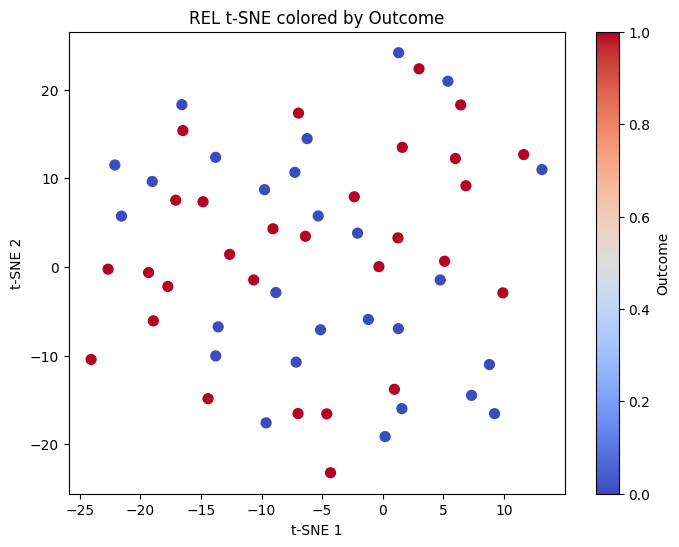

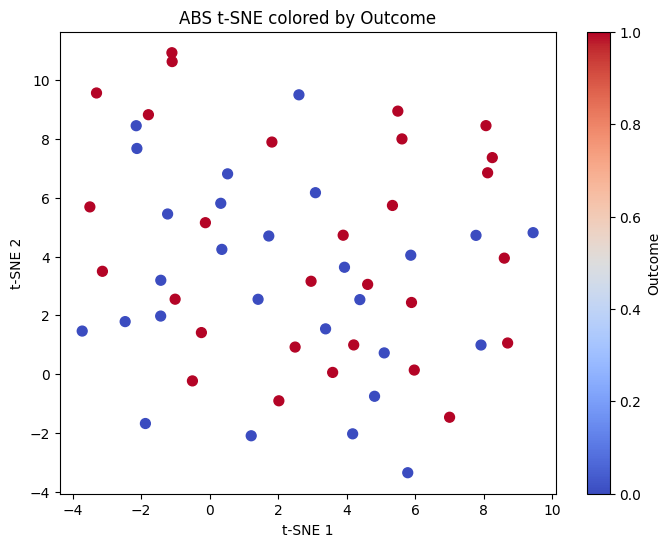

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming graphs_by_sid is already loaded
graphs_by_sid = load_and_preprocess_graphs(file_path, abs_keep_fraction=0.4, rel_keep_fraction=0.4)

# --- REL embeddings ---
rel_embeddings = []
rel_outcomes = []

for graph in graphs_by_sid.values():
    if 'rel' in graph:
        rel_embeddings.append(graph['rel'].flatten())
        rel_outcomes.append(graph['outcome'])

rel_embeddings = np.stack(rel_embeddings)
rel_outcomes = np.array(rel_outcomes)

tsne_rel = TSNE(n_components=2, random_state=42, perplexity=10)
rel_2d = tsne_rel.fit_transform(rel_embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(rel_2d[:,0], rel_2d[:,1], c=rel_outcomes, cmap='coolwarm', s=50)
plt.colorbar(scatter, label='Outcome')
plt.title('REL t-SNE colored by Outcome')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# --- ABS embeddings ---
abs_embeddings = []
abs_outcomes = []

for graph in graphs_by_sid.values():
    if 'abs' in graph:
        abs_embeddings.append(graph['abs'].flatten())
        abs_outcomes.append(graph['outcome'])

abs_embeddings = np.stack(abs_embeddings)
abs_outcomes = np.array(abs_outcomes)

tsne_abs = TSNE(n_components=2, random_state=42, perplexity=10)
abs_2d = tsne_abs.fit_transform(abs_embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(abs_2d[:,0], abs_2d[:,1], c=abs_outcomes, cmap='coolwarm', s=50)
plt.colorbar(scatter, label='Outcome')
plt.title('ABS t-SNE colored by Outcome')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


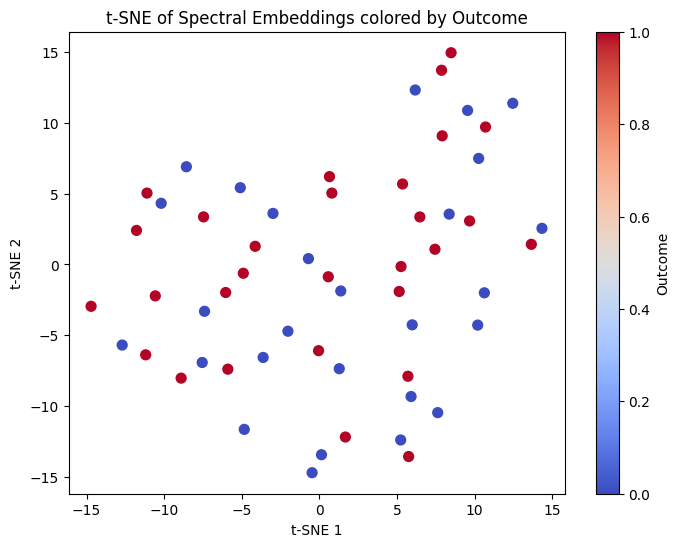

Spectral Graph Feature Correlations with Outcome
Mean absolute correlation: 0.09631452321810424
Max absolute correlation: 0.3029370211245258


In [ ]:


#SANITY CHECK doing TSNE representation of spectral embeddings graphs


file_path = '/content/drive/Shared drives/GNN/RestingStateDataforAlex_3Networks.xlsx'
graphs_by_sid = load_and_preprocess_graphs(file_path, abs_keep_fraction=0.4, rel_keep_fraction=0.3)

for g in graphs_by_sid.values():
    g['spectral_embedding'] = spectral_embedding(g['abs'], k=5)

# Gather all spectral embeddings and outcomes
embeddings = []
outcomes = []

for sid, graph in graphs_by_sid.items():
    if 'spectral_embedding' in graph:
        emb = graph['spectral_embedding'].flatten()  # flatten per-graph embedding
        embeddings.append(emb)
        outcomes.append(graph['outcome'])

embeddings = np.stack(embeddings)
outcomes = np.array(outcomes)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
emb_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=outcomes, cmap='coolwarm', s=50)
plt.colorbar(scatter, label='Outcome')
plt.title('t-SNE of Spectral Embeddings colored by Outcome')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


import numpy as np
from scipy.stats import pointbiserialr

def feature_outcome_correlation(graphs_by_sid, use_spectral=True):
    features = []
    outcomes = []

    for graph in graphs_by_sid.values():
        # Flatten features
        if use_spectral:
            emb = graph.get('spectral_embedding')
            if emb is None:
                continue
        else:
            emb = graph['abs']  # or 'rel'
        features.append(emb.flatten())
        outcomes.append(graph['outcome'])

    features = np.array(features)
    outcomes = np.array(outcomes)

    # Compute correlation per feature
    corrs = []
    for i in range(features.shape[1]):
        corr, _ = pointbiserialr(outcomes, features[:, i])
        corrs.append(corr)

    corrs = np.array(corrs)
    print(f"{'Spectral' if use_spectral else 'ABS'} Graph Feature Correlations with Outcome")
    print("Mean absolute correlation:", np.mean(np.abs(corrs)))
    print("Max absolute correlation:", np.max(np.abs(corrs)))
    return corrs

spectral_corrs = feature_outcome_correlation(graphs_by_sid, use_spectral=True)

